### Import the Necessary Libraries

In [1]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pydicom as dcm
import os

### Load Datasets

In [3]:
label_data = pd.read_csv("Data/stage_2_train_labels.csv")

In [4]:
label_data.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [5]:
class_info = pd.read_csv("Data/stage_2_detailed_class_info.csv")

In [6]:
class_info.head(4)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal

### Database table Preprocessing

In [7]:
def check_for_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) #percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # putting the above two together
    return missing_data # return the dataframe

In [8]:
check_for_missing_data(label_data)

Total   Percent
height     20672  0.683892
width      20672  0.683892
y          20672  0.683892
x          20672  0.683892
Target         0  0.000000
patientId      0  0.000000

In [9]:
check_for_missing_data(class_info)

Total  Percent
class          0      0.0
patientId      0      0.0

No missing value found in the class_info table

All the target values are filled therefore there is no empty value, cell with Nan or empty cell are having no phenumonia so we should replace those value with 0

In [10]:
label_data.fillna(0, inplace=True)

In [11]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


x, y, width, height are float type therefore we can say that they all have the numerical values

In [12]:
label_data[label_data["Target"]==1].describe().T

count        mean         std   min    25%    50%    75%    max
x       9555.0  394.047724  204.574172   2.0  207.0  324.0  594.0  835.0
y       9555.0  366.839560  148.940488   2.0  249.0  365.0  478.5  881.0
width   9555.0  218.471376   59.289475  40.0  177.0  217.0  259.0  528.0
height  9555.0  329.269702  157.750755  45.0  203.0  298.0  438.0  942.0
Target  9555.0    1.000000    0.000000   1.0    1.0    1.0    1.0    1.0

from here we can get an idea of mean width and mean height of the phenumoniatic image areas

In [13]:
np.unique(class_info["class"])

array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
      dtype=object)

We can divide the dataset in 3 classes 

1. confirmed phenumoia
2. partial phenumonia
3. Normal Lungs

In [14]:
np.unique(label_data["Target"])

array([0, 1])

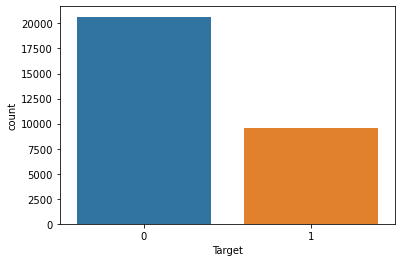

In [15]:
sns.countplot(label_data["Target"])

We may need to upsample 1 so that the model doesn't biase

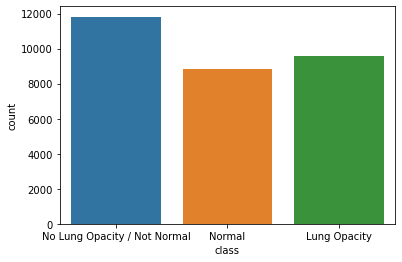

In [16]:
sns.countplot(class_info["class"])

In [17]:
class_info[class_info["patientId"]=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal

In [18]:
label_data[label_data['patientId']=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

patientId    x    y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  0.0  0.0    0.0     0.0       0

No Lung Opacity / Not Normal has been classified as Target 0

In [19]:
class_info[class_info["patientId"]=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

patientId   class
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  Normal

In [20]:
label_data[label_data['patientId']=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

patientId    x    y  width  height  Target
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  0.0  0.0    0.0     0.0       0

Noraml has been classified as 0 too

In [21]:
class_info[class_info["patientId"]=='00436515-870c-4b36-a041-de91049b9ab4']

patientId         class
4  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity

In [22]:
label_data[label_data['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

Lung Opacity has been classified as 1 and other classes has been classified as Normal indicated as 0

The class value 'No Lung Opacity / Not Normal ' is classified as 0 as it could be case of other complication which is not phenumonia

In [23]:
# Images Example
train_images_dir = 'Data/stage_2_train_images/'
train_images = [f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]
test_images_dir = 'Data/stage_2_test_images/'
test_images = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
print('5 Training images', train_images[:5]) # Print the first 5

5 Training images ['7be6b4de-afe9-43c0-a581-0f49608c8976.dcm', '2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm', 'd8e66874-305e-4c80-9b75-5e764eb718ff.dcm', '22f2d3ec-f7ea-4778-850d-bb111590202f.dcm', 'cdaa07d4-4234-4cd2-b9bf-abbf5aed1bb4.dcm']


In [24]:
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Number of train images: 26684
Number of test images: 3000


Now we have to count of Train and Test Data here

In [25]:
dicom_file_path = os.path.join("Data/stage_2_train_images/0b510189-2f09-4273-89fe-4ce4581ae69a.dcm")
file = dcm.read_file(dicom_file_path)
file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.7608.1517874332.600508
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.7608.1517874332.600508
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

The above gives more information on the individual data, but in our modeling case these are not relevant 

### Data Visualisation 

In [26]:
def show_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = f"Data/stage_2_train_images/{patientImage}"
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

Let display some images that has been classified as a case of phenumonia

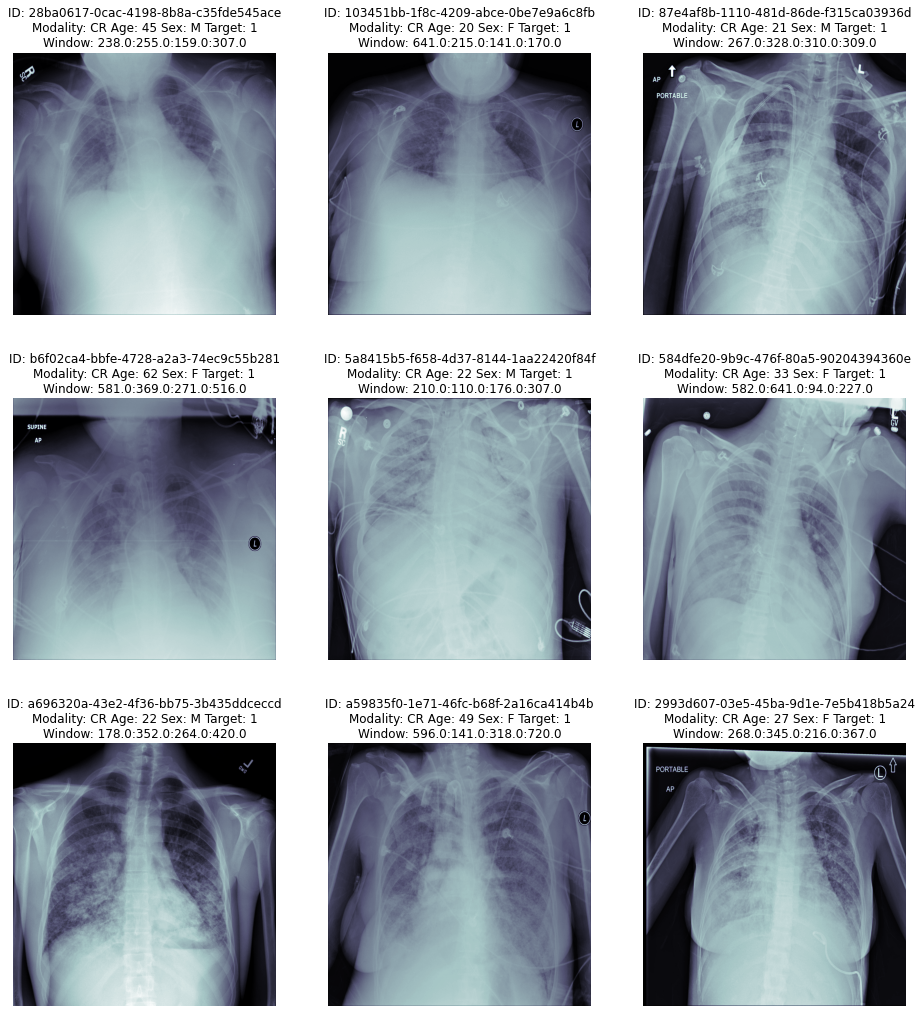

In [27]:
show_images(label_data[label_data['Target']==1].sample(9))

In [ ]:
Also display the image of normal lungs so that we can have idea about how normal lungs will look

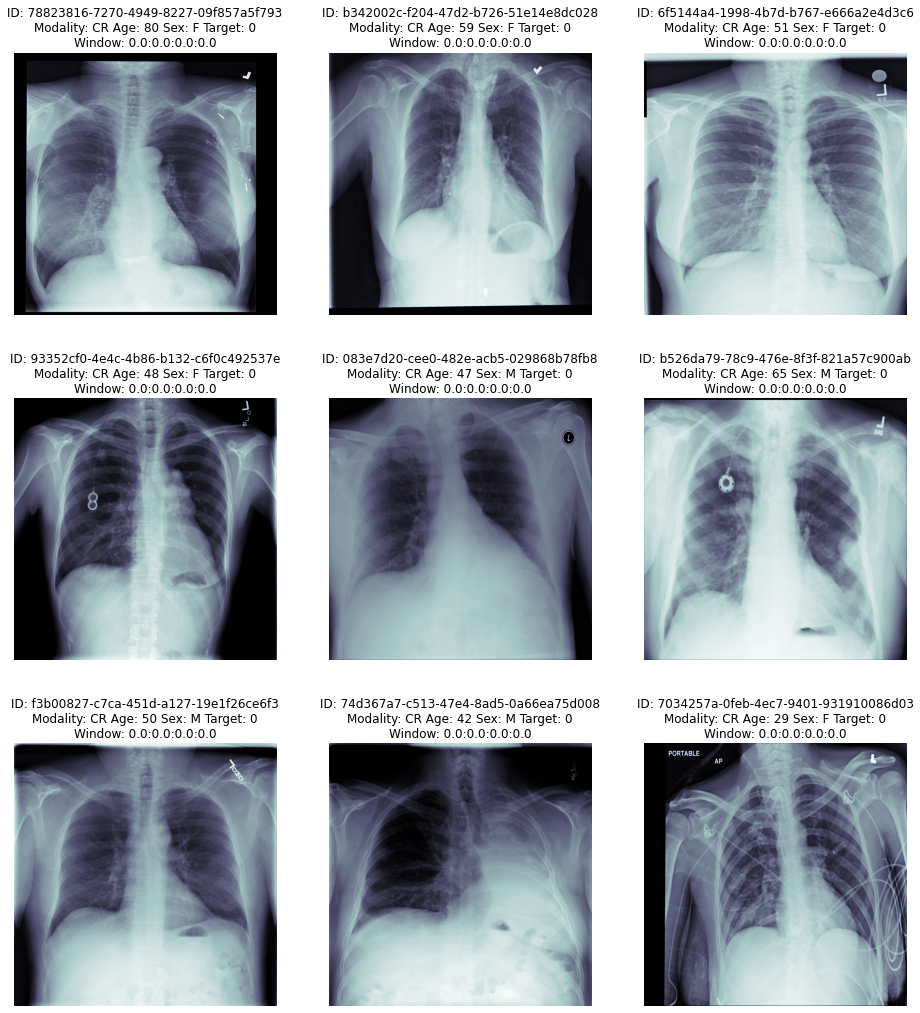

In [28]:
show_images(label_data[label_data['Target']==0].sample(9))